GP Regression with GPflow
--

*James Hensman, 2015, 2016*

GP regression (with Gaussian noise) is the most straightforward GP model in GPflow. Because of the conjugacy of the latent process and the noise, the marginal likelihood $p(\mathbf y\,|\,\theta)$ can be computed exactly.

This notebook shows how to build a GPR model and estimate the parameters $\theta$ by both maximum likelihood and MCMC. 

In [1]:
import gpflow
import numpy as np
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot

/Users/artemav/anaconda3/envs/tf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/artemav/code/GPflow/gpflow/likelihoods/likelihoods.py:61: DeprecationWarning: invalid escape sequence \i
  """
/Users/artemav/code/GPflow/gpflow/likelihoods/likelihoods.py:89: DeprecationWarning: invalid escape sequence \l
  """
/Users/artemav/code/GPflow/gpflow/likelihoods/likelihoods.py:113: DeprecationWarning: invalid escape sequence \i
  """
/Users/artemav/code/GPflow/gpflow/likelihoods/likelihoods.py:530: DeprecationWarning: invalid escape sequence \i
  """
/Users/artemav/code/GPflow/gpflow/likelihoods/likelihoods.py:554: DeprecationWarning: invalid escape sequence \l
  """
/Users/artemav/code/GPflow/gpflow/likelihoods/likelihoods.py:575: DeprecationWarn

First build a simple data set. 

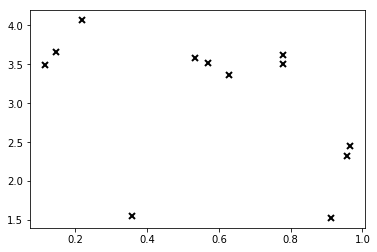

In [2]:
N = 12
X = np.random.rand(N,1)
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3
plt.plot(X, Y, 'kx', mew=2)

### Model construction

A GPflow model is created by instantiating one of the GPflow model classes, in this case GPR. We'll make a kernel `k` and instantiate a GPR object using the generated data and the kernel. We'll set the variance of the likelihood to a sensible initial guess, too. 

In [3]:
k = gpflow.kernels.Matern52(1, lengthscales=0.3)
m = gpflow.models.GPR(X, Y, kernel=k)
m.likelihood.variance <<= 0.01

### Prediction

GPflow models have several prediction methods:

 - `m.predict_f` returns the mean and variance of the latent function (f) at the points Xnew. 

 - `m.predict_f_full_cov` additionally returns the full covariance matrix of the prediction.

 - `m.predict_y` returns the mean and variance of a new data point (i.e. includes the noise varaince). In the case of non-Gaussian likelihoods, the variance is computed by (numerically) integrating the non-Gaussian likelihood. 

 - `m.predict_f_samples` returns samples of the latent function

 - `m.predict_density` returns the log-density of the points Ynew at Xnew. 
 
We'll use `predict_y` to make a simple plotting function. 

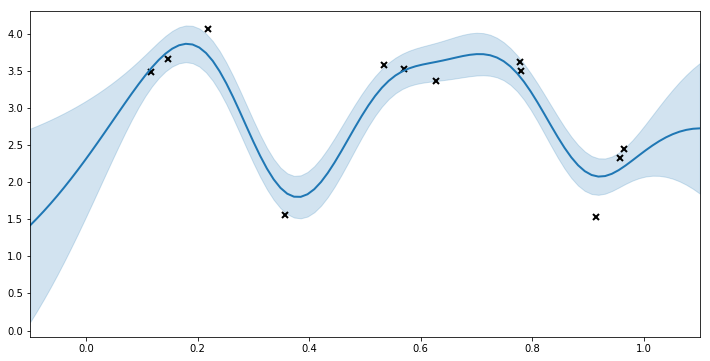

In [5]:
def plot(m):
    xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, mean, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     mean[:,0] - 2*np.sqrt(var[:,0]),
                     mean[:,0] + 2*np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)
    plt.xlim(-0.1, 1.1)

plot(m)

### Using mean functions

All GPflow models can have parameterized mean functions, some simple ones are provided in `gpflow.mean_functions`. Here's a model with a Linear mean function. 

In [5]:
k = gpflow.kernels.Matern52(1, lengthscales=0.3)
meanf = gpflow.mean_functions.Linear(1.0, 0.0)
m = gpflow.models.GPR(X, Y, k, meanf)
m.likelihood.variance <<= 0.01

### Maximum Likelihood estimation of $\theta$

Getting the ML estimate of the parameters is a simple call to `minimize` method of the optimizer's instance, for e.g. `gpflow.train.ScipyOptimizer()`. By default, GPflow plugs into the L-BFGS-B algorithm via scipy. Here are the parameters before optimization: 

In [6]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,0.3
GPR/kern/variance,Parameter,None,+ve,True,(),True,1.0
GPR/mean_function/b,Parameter,None,(none),True,(),True,0.0
GPR/mean_function/A,Parameter,None,(none),True,"(1, 1)",True,[[1.0]]
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.01


Here are the parameters after optimization, and a new plot. 

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 9.122512
  Number of iterations: 21
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 9.122512
  Number of iterations: 21
  Number of functions evaluations: 23


,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,0.0602623675564972
GPR/kern/variance,Parameter,None,+ve,True,(),True,0.6050496883970332
GPR/mean_function/b,Parameter,None,(none),True,(),True,3.6281027899993705
GPR/mean_function/A,Parameter,None,(none),True,"(1, 1)",True,[[-1.38007666436]]
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.002893234099970401


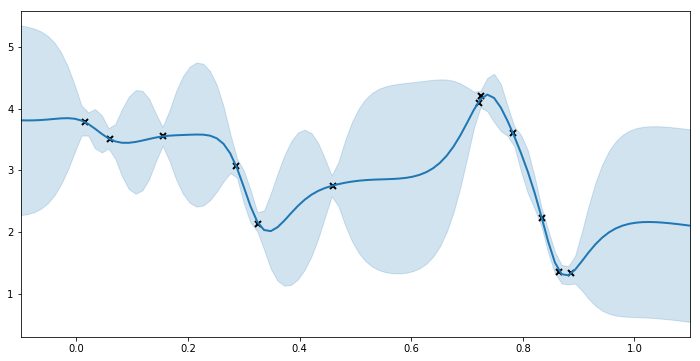

In [7]:
gpflow.train.ScipyOptimizer().minimize(m)
plot(m)
m.as_pandas_table()

Note that the local optimum found by Maximum Likelihood may not be the one you want, e.g. it may be overfitting or be oversmooth. This depends on the initial values of hyperparameters and is specific to each data set. This discussion is beyond the scope of GPflow; an introduction can be found, for example, at [A Practical Guide to Gaussian Processes](https://drafts.distill.pub/gp/).

### MCMC for $\theta$

Here's a quick demonstration of how to obtain posteriors over the hyper-parameters in GP regression. First, we'll set some priors on the kernel parameters, then we'll run MCMC and see how much posterior uncertainty there is in the parameters.

First we'll choose rather arbitrary priors. 


In [8]:
m.clear()
m.kern.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m.kern.variance.prior = gpflow.priors.Gamma(1., 1.)
m.likelihood.variance.prior = gpflow.priors.Gamma(1., 1.)
m.mean_function.A.prior = gpflow.priors.Gaussian(0., 10.)
m.mean_function.b.prior = gpflow.priors.Gaussian(0., 10.)
m.compile()
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,"Ga([ 1.],[ 1.])",+ve,True,(),True,0.0602623675564972
GPR/kern/variance,Parameter,"Ga([ 1.],[ 1.])",+ve,True,(),True,0.6050496883970332
GPR/mean_function/b,Parameter,"N([ 0.],[ 10.])",(none),True,(),True,3.6281027899993705
GPR/mean_function/A,Parameter,"N([ 0.],[ 10.])",(none),True,"(1, 1)",True,[[-1.38007666436]]
GPR/likelihood/variance,Parameter,"Ga([ 1.],[ 1.])",+ve,True,(),True,0.002893234099970401


In [9]:
sampler = gpflow.train.HMC()
samples = sampler.sample(m, num_samples=gpflow.test_util.notebook_niter(500), epsilon=0.05, lmin=10, lmax=20, logprobs=False)

Text(0,0.5,'parameter value')

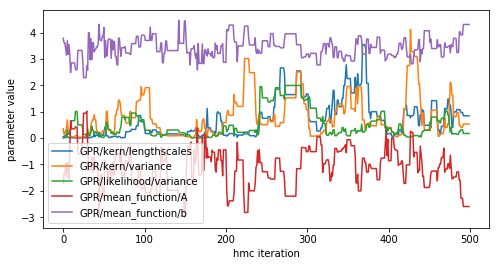

In [10]:
plt.figure(figsize=(8,4))
for i, col in samples.iteritems():
    plt.plot(col, label=col.name)
plt.legend(loc=0)
plt.xlabel('hmc iteration')
plt.ylabel('parameter value')

Note that the sampler runs in unconstrained space (so that positive parameters remain positive, parameters that are not trainable are ignored), but GPflow returns a dataframe with values in the true units.

For serious analysis you most certainly want to run the sampler longer, with multiple chains and convergence checks. This will do for illustration though!

Text(0,0.5,'signal_variance')

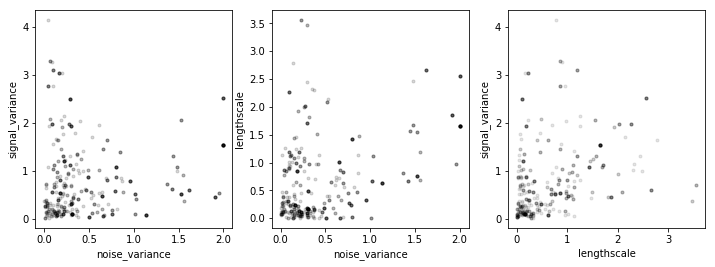

In [11]:
f, axs = plt.subplots(1,3, figsize=(12,4))

axs[0].plot(samples['GPR/likelihood/variance'],
            samples['GPR/kern/variance'], 'k.', alpha = 0.15)
axs[0].set_xlabel('noise_variance')
axs[0].set_ylabel('signal_variance')

axs[1].plot(samples['GPR/likelihood/variance'],
            samples['GPR/kern/lengthscales'], 'k.', alpha = 0.15)
axs[1].set_xlabel('noise_variance')
axs[1].set_ylabel('lengthscale')

axs[2].plot(samples['GPR/kern/lengthscales'],
            samples['GPR/kern/variance'], 'k.', alpha = 0.1)
axs[2].set_xlabel('lengthscale')
axs[2].set_ylabel('signal_variance')

To plot the posterior of predictions, we'll iterate through the samples and set the model state with each sample. Then, for that state (set of hyper-parameters) we'll draw some samples from the prediction function.

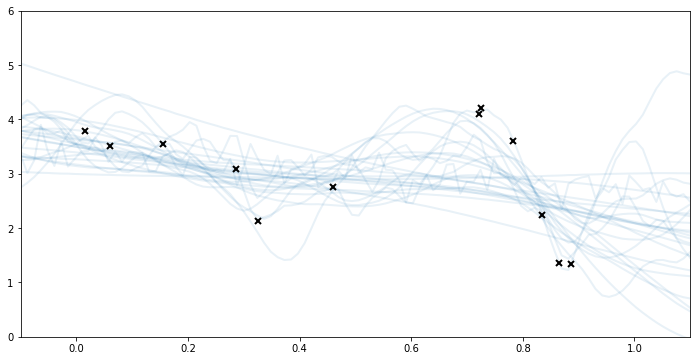

In [12]:
#plot the function posterior
xx = np.linspace(-0.1, 1.1, 100)[:,None]
plt.figure(figsize=(12, 6))
for i, s in samples.iloc[::20].iterrows():
    f = m.predict_f_samples(xx, 1, initialize=False, feed_dict=m.sample_feed_dict(s))
    plt.plot(xx, f[0,:,:], 'C0', lw=2, alpha=0.1)
    
plt.plot(X, Y, 'kx', mew=2)
_ = plt.xlim(xx.min(), xx.max())
_ = plt.ylim(0, 6)

Note the bimodal posterior: the data can be explained by a very smooth function (with lots of noise) or as a rough, short lengthscale function.